In [4]:
import os
import datetime
import warnings 
warnings.filterwarnings('ignore') 
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_federated as tff

In [6]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()


b'Hello, World!'

In [9]:
csv_path = "Data/data_Florida_2005_2015_10.csv"
cols = ['average_demand', 'No_of_energy_intensive_industry', 'no_of_energy_non_Intensive_Industry', 'gdp_growth', 'popultion', 'max temp', 'mean temp', 'min temp', 'load_share', 'average_retail_sales']
df = pd.read_csv(csv_path) 
df.head()

,average_demand,No_of_energy_intensive_industry,no_of_energy_non_Intensive_Industry,gdp_growth,popultion,max temp,mean temp,min temp,load_share,average_retail_sales
0,1576.666667,4240,7304,0.810100,17773.608997,72.266667,61.266667,50.366667,9.287986,6.090000
1,1637.333333,4243,7278,1.434778,17800.980598,84.100000,73.666667,63.166667,9.410322,6.240000
2,1700.333333,4241,7270,3.368418,17855.723801,91.300000,82.433333,73.566667,7.467319,6.713333
3,1683.333333,4268,7264,0.525937,17937.838604,76.300000,65.966667,55.633333,9.360693,6.803333
4,1540.000000,4317,8247,2.272623,18047.325009,73.500000,61.300000,49.100000,9.231507,7.516667


In [15]:

start_year = 2005
end_year = 2015

quarters = []
for year in range(start_year, end_year + 1):
    for quarter in range(1, 5):
        for month in range(1 + (quarter - 1) * 3, 4 + (quarter - 1) * 3 , 4):
            quarters.append(datetime.datetime(year, month, 1))

print(quarters)
print(len(quarters))

quarter_date = pd.to_datetime(quarters)

[datetime.datetime(2005, 1, 1, 0, 0), datetime.datetime(2005, 4, 1, 0, 0), datetime.datetime(2005, 7, 1, 0, 0), datetime.datetime(2005, 10, 1, 0, 0), datetime.datetime(2006, 1, 1, 0, 0), datetime.datetime(2006, 4, 1, 0, 0), datetime.datetime(2006, 7, 1, 0, 0), datetime.datetime(2006, 10, 1, 0, 0), datetime.datetime(2007, 1, 1, 0, 0), datetime.datetime(2007, 4, 1, 0, 0), datetime.datetime(2007, 7, 1, 0, 0), datetime.datetime(2007, 10, 1, 0, 0), datetime.datetime(2008, 1, 1, 0, 0), datetime.datetime(2008, 4, 1, 0, 0), datetime.datetime(2008, 7, 1, 0, 0), datetime.datetime(2008, 10, 1, 0, 0), datetime.datetime(2009, 1, 1, 0, 0), datetime.datetime(2009, 4, 1, 0, 0), datetime.datetime(2009, 7, 1, 0, 0), datetime.datetime(2009, 10, 1, 0, 0), datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2010, 4, 1, 0, 0), datetime.datetime(2010, 7, 1, 0, 0), datetime.datetime(2010, 10, 1, 0, 0), datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2011, 4, 1, 0, 0), datetime.datetime(2011, 7, 1, 0

In [17]:
df.index = quarter_date

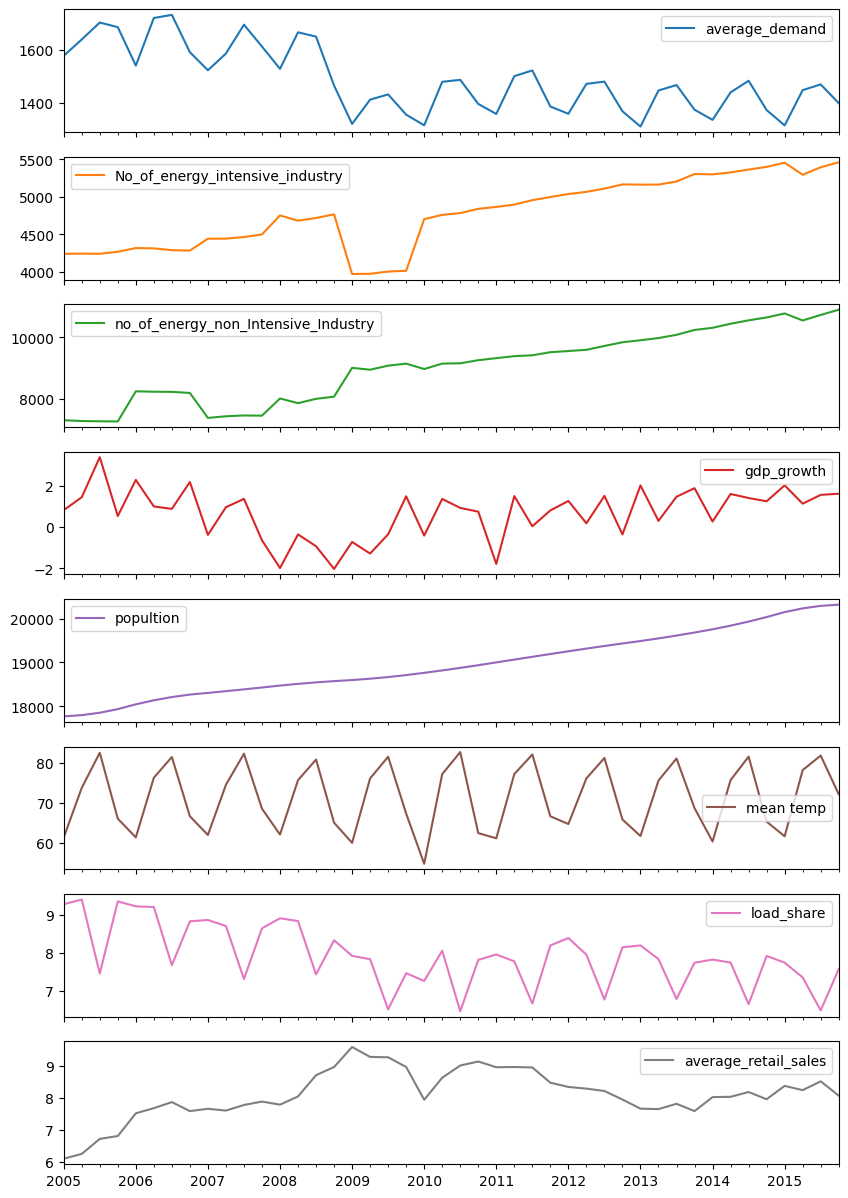

In [21]:
plot_cols =  ['average_demand', 'No_of_energy_intensive_industry', 'no_of_energy_non_Intensive_Industry', 'gdp_growth', 'popultion', 'mean temp', 'load_share', 'average_retail_sales']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True , figsize=(10,15))


In [25]:
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
average_demand,44.0,1487.007576,121.375291,1313.000000,1384.666667,1471.000000,1578.750000,1729.000000
No_of_energy_intensive_industry,44.0,4771.454545,459.748134,3971.000000,4316.000000,4775.500000,5164.500000,5461.000000
no_of_energy_non_Intensive_Industry,44.0,9045.227273,1147.866248,7264.000000,8056.500000,9154.500000,9928.000000,10904.000000
gdp_growth,44.0,0.672904,1.204722,-2.028477,-0.357489,0.935674,1.481386,3.368418
popultion,44.0,18960.245636,724.335561,17773.608997,18419.481610,18847.498702,19502.591432,20315.458548
max temp,44.0,81.846970,7.545255,66.000000,75.750000,82.600000,89.333333,91.600000
mean temp,44.0,71.307576,8.304835,54.700000,64.066667,72.866667,78.758333,82.600000
min temp,44.0,60.759848,9.128606,43.366667,52.541667,62.933333,68.808333,73.566667
load_share,44.0,7.929508,0.817815,6.474131,7.461234,7.843301,8.462275,9.410322
average_retail_sales,44.0,8.117955,0.768944,6.090000,7.675833,8.041667,8.656667,9.603333


In [23]:
df.skew()

average_demand                         0.461308
No_of_energy_intensive_industry       -0.173698
no_of_energy_non_Intensive_Industry   -0.126051
gdp_growth                            -0.509154
popultion                              0.263654
max temp                              -0.158506
mean temp                             -0.107178
min temp                              -0.052071
load_share                             0.024761
average_retail_sales                  -0.498827
dtype: float64

* No skewness in the data 
* Mean ~ Median
* 

### Feature Engineering 

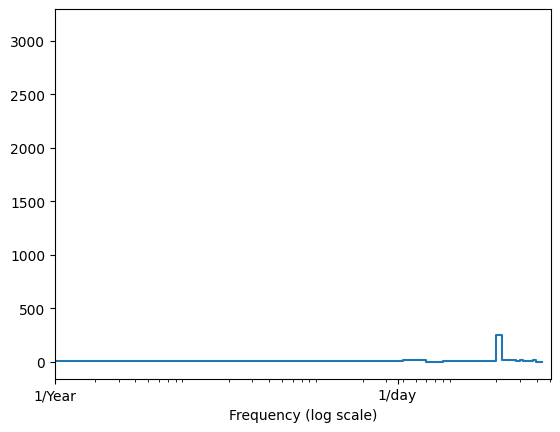

In [37]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [38]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


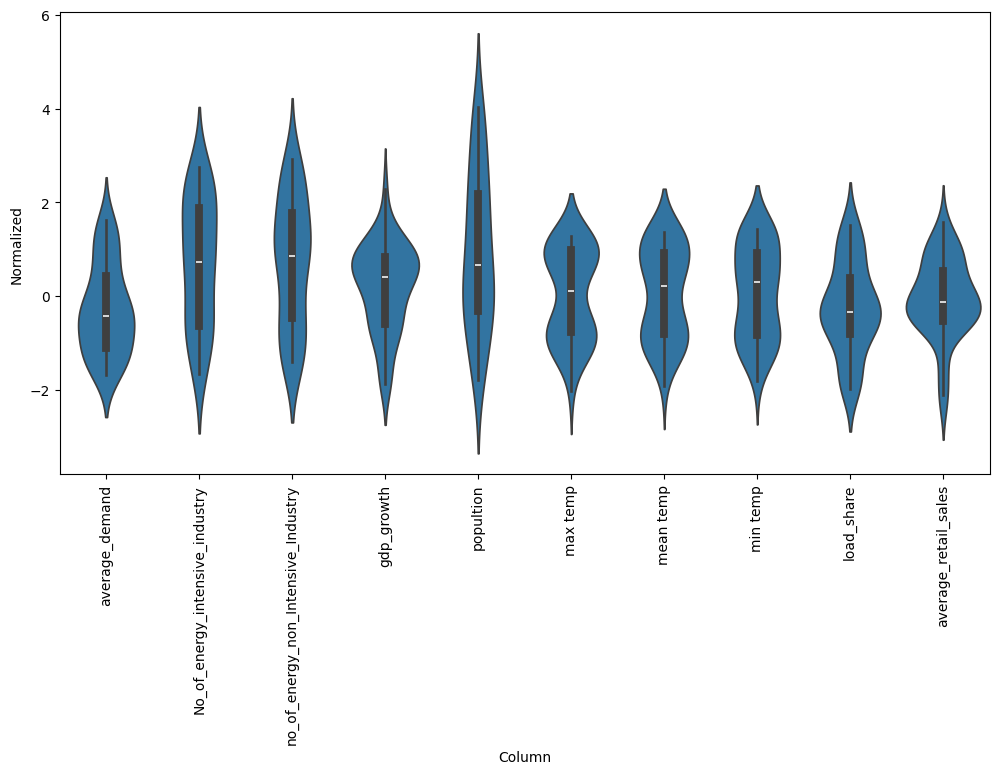

In [39]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [40]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [41]:
w1 = WindowGenerator(input_width=7, label_width=1, shift=1,
                     label_columns=['average_demand'])
w1


Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['average_demand']

In [42]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [43]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['average_demand'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['average_demand']

In [52]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[10:10+w2.total_window_size]),
                           np.array(train_df[20:20+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


<tf.Tensor: shape=(3, 6, 10), dtype=float64, numpy=
array([[[ 0.42290656, -0.8509169 , -1.35633738,  0.31364389,
         -1.78794228, -1.21321813, -1.137885  , -1.0555367 ,
          1.37109508, -2.26705242],
        [ 0.90446439, -0.84204703, -1.38734211,  0.79418408,
         -1.72512836,  0.3129776 ,  0.3224182 ,  0.32187413,
          1.51636435, -2.10295823],
        [ 1.40454368, -0.84796028, -1.39688202,  2.28165697,
         -1.59950051,  1.24159247,  1.35483686,  1.44102042,
         -0.79088224, -1.58514989],
        [ 1.26960165, -0.76813138, -1.40403696,  0.09504872,
         -1.41105875, -0.69302183, -0.58438298, -0.48878954,
          1.45743084, -1.48669337],
        [ 0.13185512, -0.62325672, -0.23181993,  1.43870501,
         -1.15980306, -1.05414984, -1.13395946, -1.19184298,
          1.30402774, -0.70633433],
        [ 1.53948571, -0.63508322, -0.24851478,  0.45139558,
         -0.94945515,  0.79448161,  0.62075971,  0.46894143,
          1.2826346 , -0.52765399]],